# Manual temporal GNN using PyG

## Data generation code

In [1]:
import torch
from torch_geometric.data import Data, Dataset

class PouchTemporalDataset(Dataset):
    def __init__(self, Ca, edge_index):
        """
        Ca: numpy array, shape (N, T)
        edge_index: torch.LongTensor, shape (2, E)
        """
        super().__init__()
        self.Ca = torch.tensor(Ca, dtype=torch.float)      # (N, T)
        self.edge_index = edge_index
        self.T = Ca.shape[1]

    def len(self):
        # One data point per (t -> t+1)
        return self.T - 1

    def get(self, idx):
        # x = Ca at time t
        x = self.Ca[:, idx].unsqueeze(1)      # (N, 1)
        # y = Ca at time t+1
        y = self.Ca[:, idx+1].unsqueeze(1)    # (N, 1)

        return Data(
            x=x,
            y=y,
            edge_index=self.edge_index
        )


## GraphSAGE -> GRU -> Linear Model

In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class SAGE_GRU_Autoregressive(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        # Spatial aggregator (GraphSAGE)
        self.sage = SAGEConv(in_channels, hidden_channels)

        # Temporal recurrence per node
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)

        # Decoder back to Ca(t+1)
        self.lin = nn.Linear(hidden_channels, 1)

        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        """
        x_t: (N, 1) – Ca at time t
        edge_index: graph edges
        h: (1, N, hidden_dim) – GRU hidden state
        """

        # 1) Spatial message passing
        g = self.sage(x_t, edge_index)       # (N, H)
        g = torch.relu(g)

        # 2) GRU expects (batch, sequence, features)
        g_seq = g.unsqueeze(0)               # (1, N, H)
        out, h_new = self.gru(g_seq, h)      # out: (1, N, H)

        # 3) Predict next Calcium
        pred = self.lin(out.squeeze(0))      # (N, 1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


In [3]:
class SAGE_GRU_Autoregressive2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        self.sage = SAGEConv(in_channels, hidden_channels)

        # GRU per node (each node is a batch element)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=False)

        self.lin = nn.Linear(hidden_channels, 1)
        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        # Spatial step
        g = self.sage(x_t, edge_index)   # (N, H)
        g = torch.relu(g)

        # Make seq_len=1, batch=N
        g_seq = g.unsqueeze(0)           # (1, N, H)

        # GRU
        out, h_new = self.gru(g_seq, h)  # h shape: (1, N, H)

        # Decode next state
        pred = self.lin(out.squeeze(0))  # (N,1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


## Training Loop

In [4]:
from torch_geometric.loader import DataLoader

def train_model(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of cells
    print(f"Training on {N} nodes.")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        # Reset GRU hidden state each epoch
        h = model.init_hidden(N)

        for data in loader:
            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")


In [5]:
def train_model2(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        h = model.init_hidden(N)

        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            # Forward
            pred, h = model(x, edge_index, h)

            # ⛔ CRITICAL: Detach hidden state so graph doesn't grow across timesteps
            h = h.detach()

            # Compute loss
            loss = loss_fn(pred, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")

## Autoregressive Rollout for Testing

In [6]:
def autoregressive_rollout(model, x0, edge_index, steps=200):
    """
    x0: (N,1) initial Ca frame
    """
    model.eval()

    N = x0.shape[0]
    h = model.init_hidden(N)

    x_t = x0
    preds = [x0.detach().cpu().numpy()]

    for _ in range(steps):
        x_next, h = model(x_t, edge_index, h)
        preds.append(x_next.detach().cpu().numpy())
        x_t = x_next

    # returns array (steps+1, N, 1)
    return np.stack(preds, axis=1)


# Pipeline

## Load a simulation output

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

ca_models_lib_mac = "/Users/scini/Documents/GitHub/Systems_Bio/ca_models_lib.py" 
ca_models_lib_path = ca_models_lib_mac  # Change this if on a different system

# Add the directory containing ca_models_lib.py to sys.path
import sys
import os
if ca_models_lib_path not in sys.path:
    sys.path.append(os.path.dirname(ca_models_lib_path))

import ca_models_lib as caml

import pandas as pd
import time


In [8]:
# Load data
folder_path_pc = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data"
folder_path_mac = r"/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data"

folder_path = folder_path_mac
# Get geometry files

# Select size
size = 'xsmall'  # Options: 'xsmall', 'small', 'medium', 'large',
# Load statics for wing disc geometries    
disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix

adj_matrix=disc_adjs[size] # Adjacency Matrix
laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
new_vertices=disc_vertices[size] # Vertices

# Number of cells
num_cells = new_vertices.shape[0]

In [9]:
disc_model_dense = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1, 
                                              t_eval_boolean=True, random_seed=123456  
                                              ) 

In [10]:
t_sim = time.perf_counter()
sig2 = disc_model_dense.simulate()
print(f"Step 2 took {time.perf_counter() - t_sim:.4f} seconds")

Step 2 took 32.8485 seconds


In [11]:
stim_cells2 = disc_model_dense.stimulated_cell_idxs

print(stim_cells2)

[175  66 173]


In [12]:
# print(Ca_conc.shape, IP3_conc.shape, R_conc.shape)
time_points2 = sig2.t
Ca_conc2 = sig2.y[:num_cells, :]
IP3_conc2 = sig2.y[num_cells:2*num_cells, :]
R_conc2 = sig2.y[2*num_cells:, :]

print(Ca_conc2.shape, IP3_conc2.shape, R_conc2.shape)

(195, 3600) (195, 3600) (195, 3600)


In [13]:
# Add 1% Gaussian noise
np.random.seed(123456)  # For reproducibility
Ca_conc2_noisy = Ca_conc2 + np.random.normal(0, 0.01 * np.std(Ca_conc2), Ca_conc2.shape)

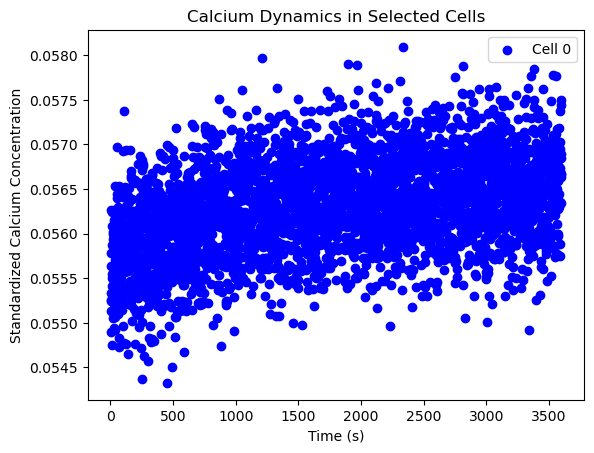

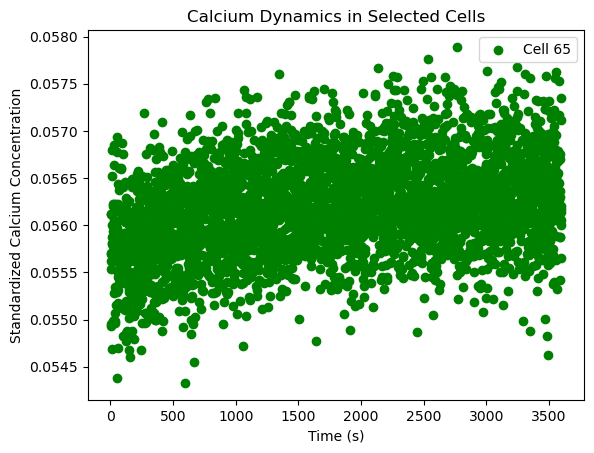

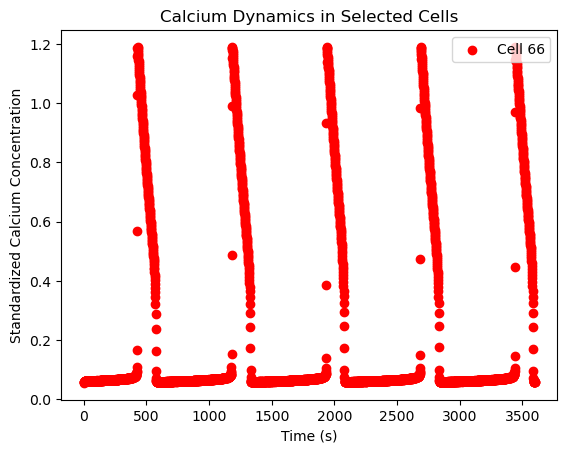

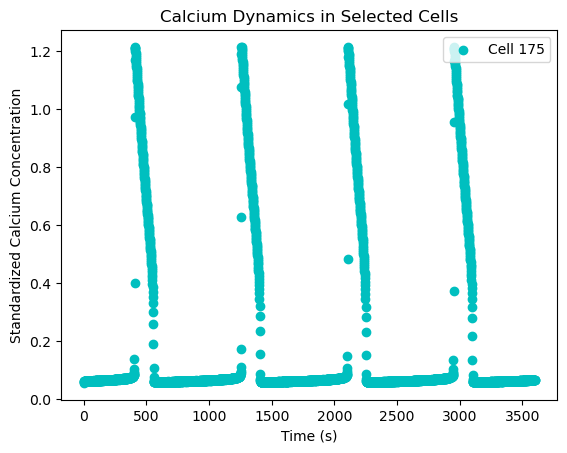

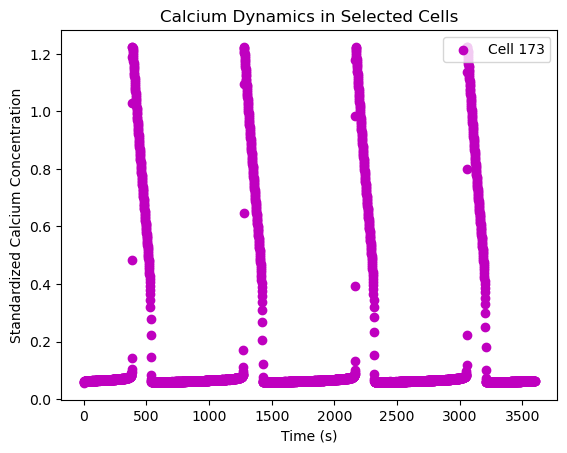

In [14]:
# Plot a few example cells to visualize the calcium dynamics

cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], Ca_conc2_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells')
    plt.legend()
    plt.show()


In [15]:
off_diag_lap = laplacian_matrix - np.diag(np.diag(laplacian_matrix))
display(off_diag_lap)

is_symmetric = np.allclose(off_diag_lap, off_diag_lap.T)
print("Symmetric?", is_symmetric)

row, col = np.nonzero(off_diag_lap)
# np.array(row)
# np.array(col)

edge_index = torch.tensor([row, col], dtype=torch.long)
print(edge_index)
print(edge_index.shape)  # Should be [2, num_edges]
edge_weight = torch.tensor(off_diag_lap[row, col], dtype=torch.float32)


print(edge_weight)
print(edge_weight.shape)  # Should be [num_edges,]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.19337977],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 10.19337977,
         0.        ,  0.        ]], shape=(195, 195))

Symmetric? True
tensor([[  0,   0,   1,  ..., 194, 194, 194],
        [  3,   5,   3,  ..., 188, 189, 192]])
torch.Size([2, 1064])
tensor([ 8.6643,  9.5087,  8.8120,  ...,  8.8206,  7.3286, 10.1934])
torch.Size([1064])


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_45365/737813101.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636709/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [16]:
# Build PouchTemporalDataset
dataset = PouchTemporalDataset(Ca_conc2_noisy, edge_index)

In [17]:
# Make the model and train it
model = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model2(model, dataset, epochs=50, lr=1e-3)

Epoch 0: Loss = 1.699586
Epoch 1: Loss = 0.069357


KeyboardInterrupt: 

In [18]:
# Autoregressive rollout
x0 = torch.tensor(Ca_conc2_noisy[:, 0]).unsqueeze(1).float()  # (N,1)
preds = autoregressive_rollout(model, x0, edge_index, steps=Ca_conc2_noisy.shape[1]-1)

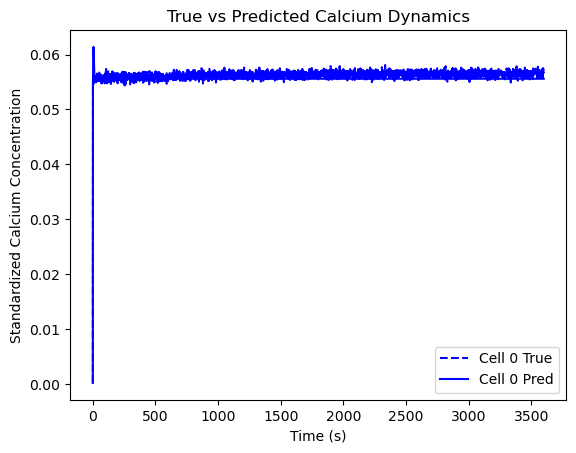

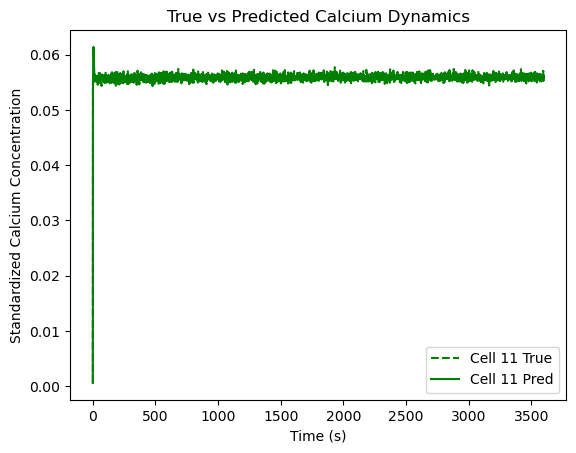

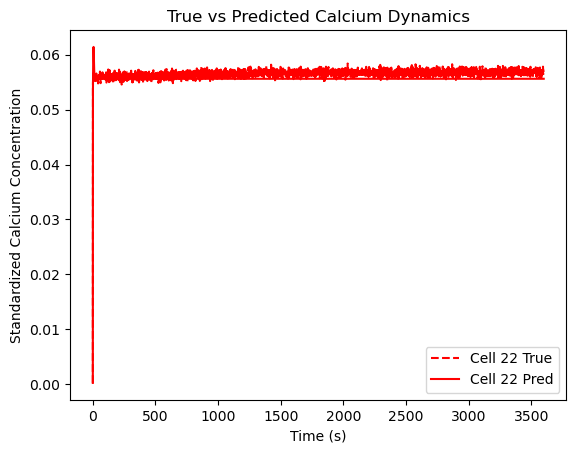

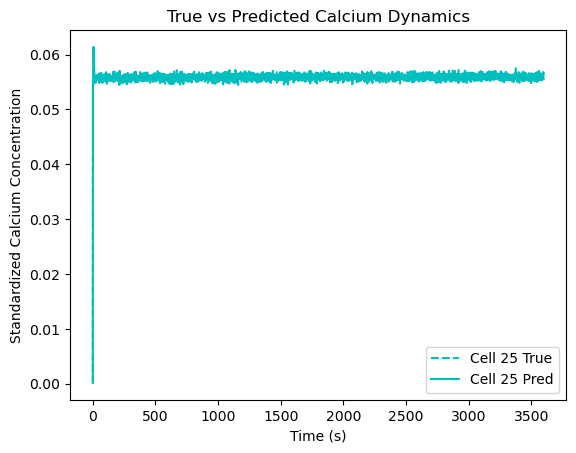

In [19]:
# Plot results for a few example cells
cell_indices = [0, 11, 22, 25 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(time_points2, Ca_conc2_noisy[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(time_points2, preds[i, :, 0], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Normal training, no autoregression

In [20]:
def train_model_nextstep(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of nodes/cells

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for data in loader:

            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            # Reset hidden state EVERY time
            h = model.init_hidden(N)

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: loss = {total_loss:.6f}")


In [21]:
def evaluate_nextstep(model, dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []

    with torch.no_grad():
        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            h = model.init_hidden(N)    # reset!
            pred, h = model(x, edge_index, h)

            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths

In [22]:
T_train = 3000
Ca = Ca_conc2_noisy

train_set = PouchTemporalDataset(Ca[:, :T_train], edge_index)
test_set  = PouchTemporalDataset(Ca[:, T_train-1:], edge_index)

In [23]:
# Train next-step model
model_nextstep = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model_nextstep(model_nextstep, train_set, epochs=50, lr=1e-3)


Epoch 0: loss = 0.418989
Epoch 1: loss = 0.061692
Epoch 2: loss = 0.043190
Epoch 3: loss = 0.047711
Epoch 4: loss = 0.043830
Epoch 5: loss = 0.039607
Epoch 6: loss = 0.042157
Epoch 7: loss = 0.040074
Epoch 8: loss = 0.040701
Epoch 9: loss = 0.040008
Epoch 10: loss = 0.040179
Epoch 11: loss = 0.040320
Epoch 12: loss = 0.038884
Epoch 13: loss = 0.038180
Epoch 14: loss = 0.038335
Epoch 15: loss = 0.037325
Epoch 16: loss = 0.037538
Epoch 17: loss = 0.037752
Epoch 18: loss = 0.036983
Epoch 19: loss = 0.036676
Epoch 20: loss = 0.037286
Epoch 21: loss = 0.036742
Epoch 22: loss = 0.037407
Epoch 23: loss = 0.036399
Epoch 24: loss = 0.036506
Epoch 25: loss = 0.036525
Epoch 26: loss = 0.036819
Epoch 27: loss = 0.036868
Epoch 28: loss = 0.036669
Epoch 29: loss = 0.036628
Epoch 30: loss = 0.036367
Epoch 31: loss = 0.036190
Epoch 32: loss = 0.036029
Epoch 33: loss = 0.036647
Epoch 34: loss = 0.035821
Epoch 35: loss = 0.035426
Epoch 36: loss = 0.035369
Epoch 37: loss = 0.035458
Epoch 38: loss = 0.035

In [24]:
# Test the model preds, truths = evaluate_nextstep(model_nextstep, test_set)
preds_list, truths_list = evaluate_nextstep(model_nextstep, test_set)

In [25]:
# Convert lists of (N,1) tensors into arrays
truths_arr = torch.stack([t.squeeze(1) for t in truths_list], dim=1).numpy()  # (N, T_test)
preds_arr  = torch.stack([p.squeeze(1) for p in preds_list],  dim=1).numpy()  # (N, T_test)

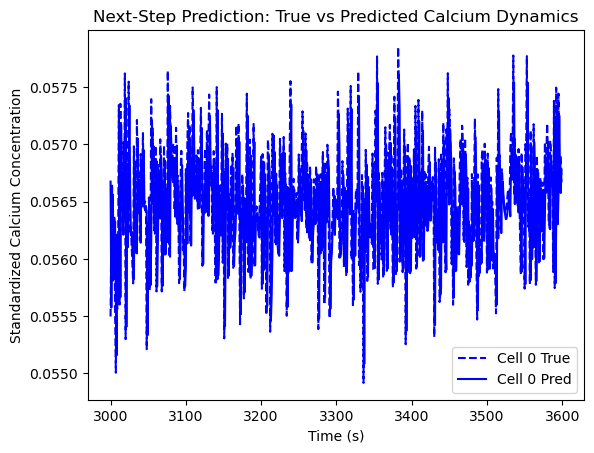

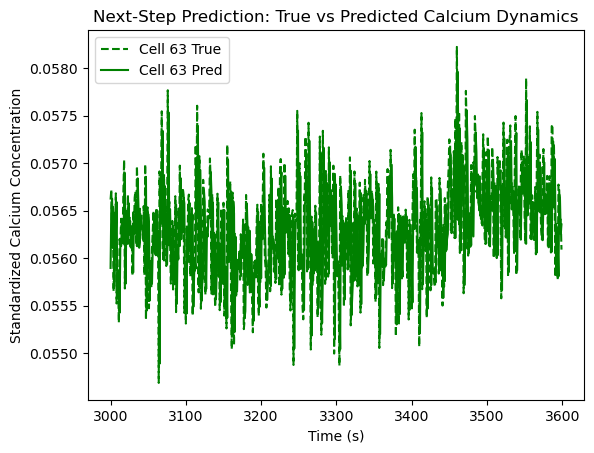

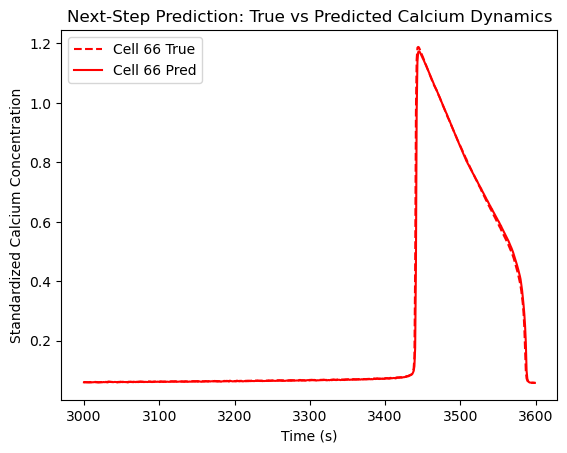

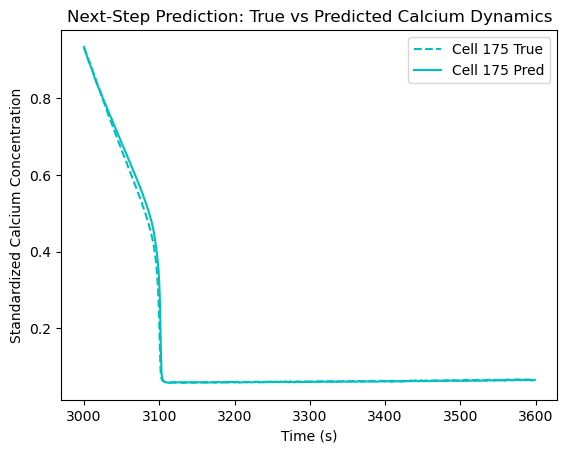

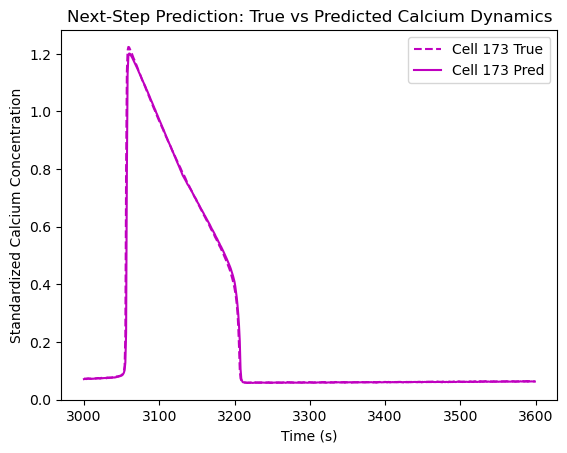

In [26]:
# Plot results for a few example cells
timepoints_test = time_points2[T_train:]

cell_indices = [0, 63, 66, 175, 173 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(timepoints_test, truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_test, preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Generate videos

In [ ]:
import matplotlib
import seaborn as sns
from matplotlib import animation
from matplotlib import colors

def make_animation(ca, vertices): # Creation of calcium video
    colormap = plt.cm.Greens
    normalize = matplotlib.colors.Normalize(vmin=np.min(ca), vmax=max(np.max(ca),1))
    with sns.axes_style("white"):
            fig=plt.figure(figsize=(25,15))
            fig.patch.set_alpha(0.)
            ax = fig.add_subplot(1,1,1)
            ax.axis('off')
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
            sm._A = []
            cbar=fig.colorbar(sm, ax=ax)
            cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
            for cell in vertices:
                ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
            patches = [matplotlib.patches.Polygon(verts) for verts in vertices ]
                    # Timestamp generator, 1 sec increments
            def time_stamp_gen(n):
                for j in range(n):
                    if j%10==0:
                        yield f"Elapsed time: {j//60:02d}:{j%60:02d}"
            time_stamps=time_stamp_gen(len(ca[0,:]))
            def init():
                return [ax.add_patch(p) for p in patches]

            def animate(frame,time_stamps):
                for j in range(len(patches)):
                    c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                    patches[j].set_facecolor(c)
                ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                return patches

            anim = animation.FuncAnimation(fig, animate, 
                                            init_func=init, 
                                            frames=ca[:,::10].T, # Calcium dynamics: [n cells x time-samples]
                                            fargs=(time_stamps,),
                                            interval=70,
                                            blit=True)
            
            return anim

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/102510724.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


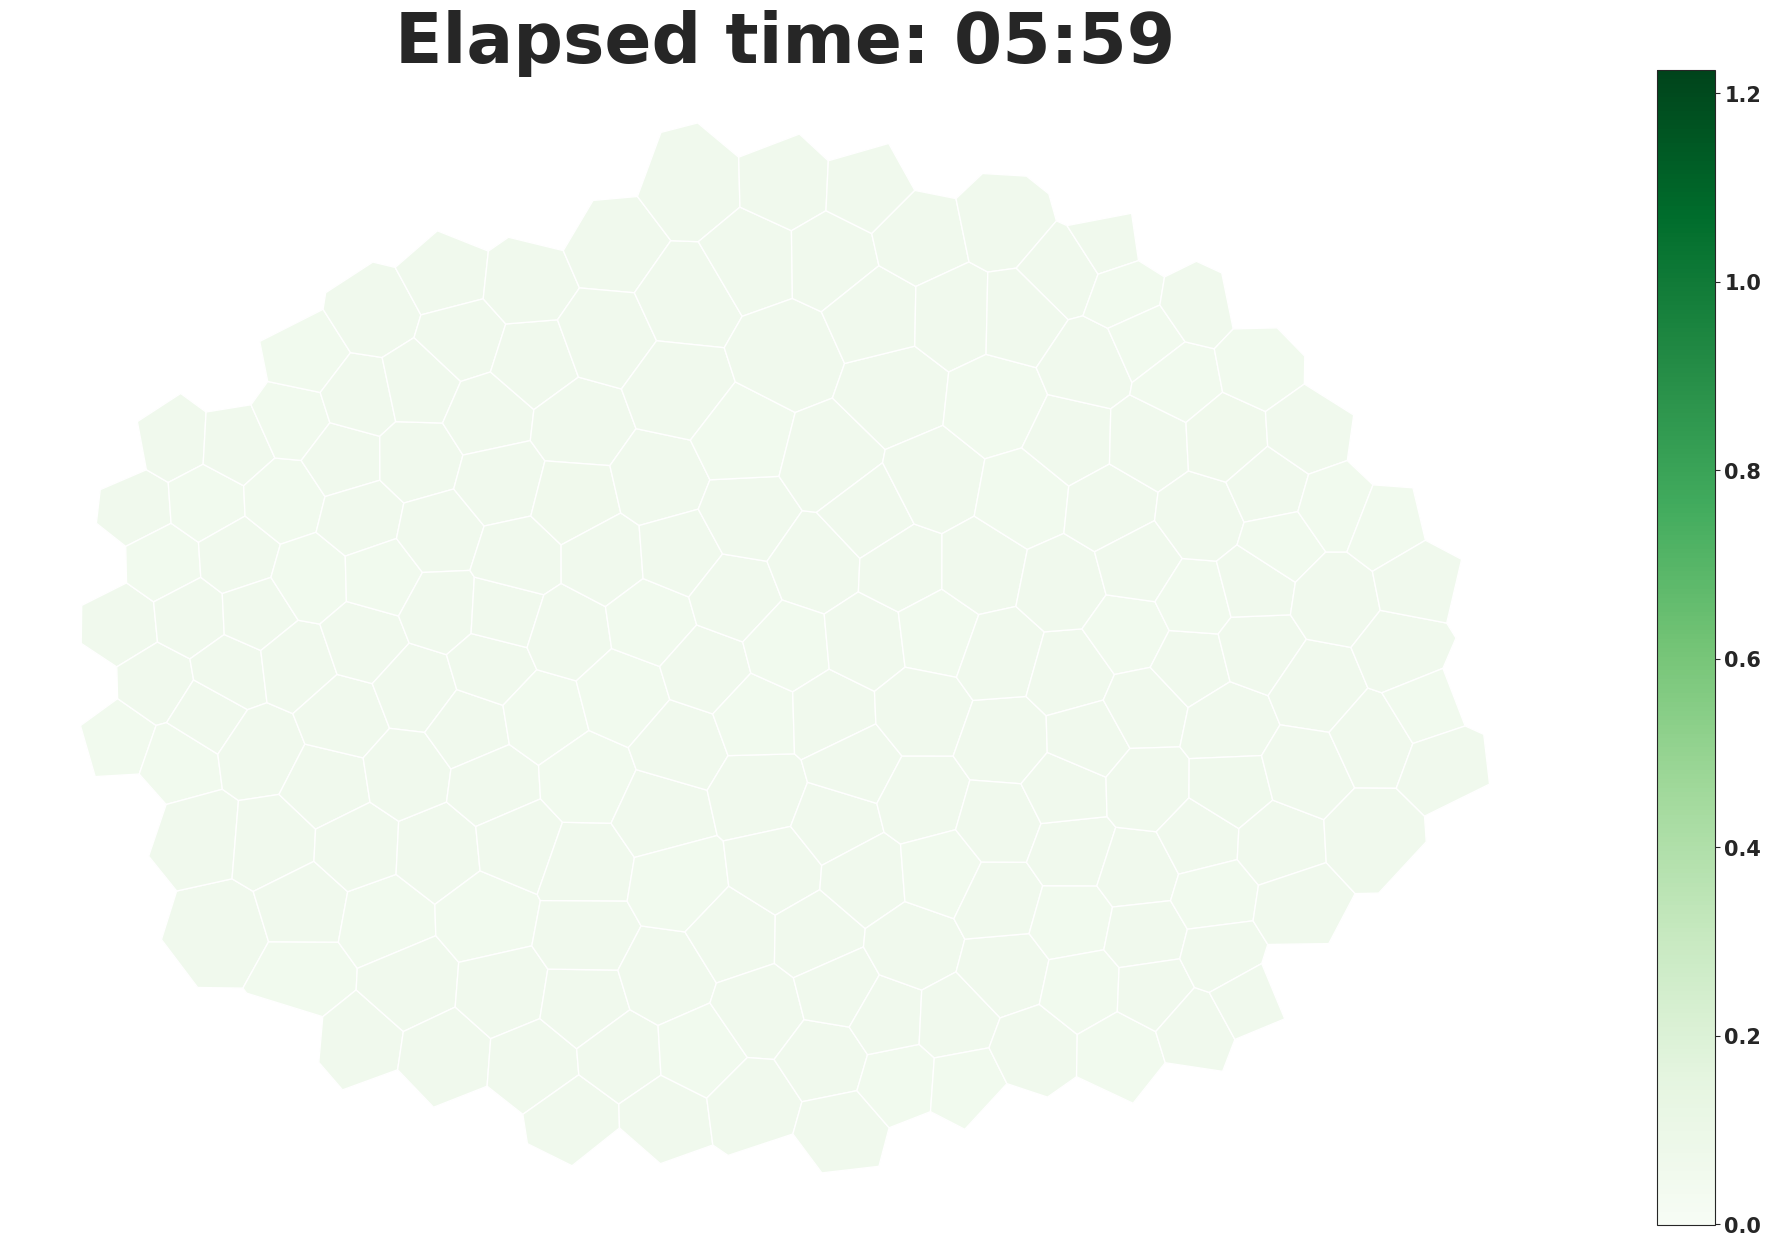

In [18]:
true_anim = make_animation(Ca_conc2_noisy, new_vertices)

# Save animation
true_anim.save('true_calcium_dynamics.mp4', writer='ffmpeg', dpi=200)